# **What are autonomous cars?**
Autonomous or self-driving cars are vehicles capable of observing its environment and operating **without human action**.

They implement **object detection** algorithms with a variety of cameras and sensors to make smart decisions.

[Check out an example of Tesla's self-driving car.](https://youtu.be/9ydhDQaLAqM)

# **What is object detection?**
Objection detection is a **computer vision** technique for locating objects in images/videos.

It combines **image classification** and **object localization** to draw bounding boxes around objects of interest and classify them.

![](https://res.cloudinary.com/practicaldev/image/fetch/s--JhcLAK3U--/c_limit%2Cf_auto%2Cfl_progressive%2Cq_auto%2Cw_880/https://dev-to-uploads.s3.amazonaws.com/uploads/articles/7qgc1cav8ch27bdqxo9n.png)

In autonomous driving, object detection is used to identify static and dynamic obstacles in the car's view. This includes surrounding cars, pedestrians, cyclists, road signs, traffic signals, and lanes. In order for cars to make real-time decisions without human input, models must have a high detection accuracy along with a fast computational speed.


# Approach 1: Sliding Windows

Let's prepare our environment for our first three approaches.

In [1]:
#@title Run this to download data and prepare our environment { display-mode: "form" }
#!pip install keras==2.12.0
!pip install tensorflow==2.10

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, DenseNet121

from PIL import Image
import gdown
from IPython import display

# Load image
# image_data_url = 'https://drive.google.com/uc?id=1y4nufMQqQByiz2TpXIyRDv1MxQU4caMy'
# image_data_path = './image-2.jpg'
# gdown.download(image_data_url, image_data_path, True)
!wget "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image-2.jpg"

# image2_url = 'https://drive.google.com/uc?id=1_WpFbGEuS2r19UeP6wekbcF0kb-0nH18'
# image2_path ='./image.jpg'
# gdown.download(image2_url, image2_path, True)
!wget "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image2.jpg"

# gif_url = 'https://drive.google.com/uc?id=1kQa0LViX33gFxdTroFVSzM11-FHypaD3'
# gif_path = './sliding.gif.png'
# gdown.download(gif_url, gif_path, True)
!wget "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/sliding.gif.png"

# Show sliding windows
def show_sliding_window():
  return display.Image(filename="sliding.gif.png")

# Construct vehicle dataset
label_car = 1
label_truck = 9

# Load data
def load_cifar10():
  (x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = cifar10.load_data()
  y_train_cifar = y_train_cifar.squeeze()
  y_test_cifar = y_test_cifar.squeeze()
  return (x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar)

# CIFAR100 classes
idx_to_class = ['background', 'car', 'truck']

# Construct vehicle dataset from CIFAR10
def construct_vehicle_dataset(data, labels, images_per_class, label_car=1, label_truck=9):
  mask_car = labels == label_car
  mask_truck = labels == label_truck

  mask_vehicles = mask_car | mask_truck
  mask_background = np.invert(mask_vehicles)

  data_car = data[mask_car]
  data_truck = data[mask_truck]
  data_background = data[mask_background][:images_per_class]

  new_data = np.vstack((data_background, data_car, data_truck))
  new_labels = np.repeat(np.array([0, 1, 2]), images_per_class, axis=0)

  return new_data, new_labels

def load_vehicle_dataset():
  (x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = load_cifar10()
  x_train, y_train = construct_vehicle_dataset(x_train_cifar, y_train_cifar, 5000)
  x_test, y_test = construct_vehicle_dataset(x_test_cifar, y_test_cifar, 1000)
  return (x_train, y_train), (x_test, y_test)

# plotting
def plot_one_image(data, labels = [], index = None, image_shape = None, fig_size=None):
  '''
  if data is a single image, display that image

  if data is a 4d stack of images, display that image
  '''
  ### cv2.imshow('image', data)
  num_dims   = len(data.shape)
  num_labels = len(labels)
  if image_shape is not None:
    target_shape = image_shape
  else:
    target_shape = (32, 32, 3)
  # reshape data if necessary
  if num_dims == 1:
    data = data.reshape(target_shape)
  if num_dims == 2:
    data = data.reshape(np.vstack[-1, image_shape])
  num_dims   = len(data.shape)

  # check if single or multiple images
  if num_dims == 3:
    if num_labels > 1:
      print('Multiple labels does not make sense for single image.')
      return

    label = labels
    if num_labels == 0:
      label = ''
    image = data

  if num_dims == 4:
    image = data[index, :]
    label = labels[index]

  # plot image of interest
  print('Label: %s'%label)
  if fig_size is not None:
    plt.figure(figsize=fig_size)
  plt.imshow(image)
  plt.show()

def model_to_string(model):
  import re
  stringlist = []
  model.summary(print_fn=lambda x: stringlist.append(x))
  sms = "\n".join(stringlist)
  sms = re.sub('_\d\d\d','', sms)
  sms = re.sub('_\d\d','', sms)
  sms = re.sub('_\d','', sms)
  return sms

def normalize(data):
  # CIFAR100 mean (0.4914, 0.4822, 0.4465) std (0.2023, 0.1994, 0.2010)
  return (data/255-np.array((0.4914, 0.4822, 0.4465))) / np.array((0.2023, 0.1994, 0.2010))

def label_to_onehot(labels):
  final_labels = np.zeros((len(labels), 3))
  for i in range(len(labels)):
    label = labels[i]
    if label == 0:
      final_labels[i,:] = np.array([1, 0, 0])
    if label == 1:
      final_labels[i,:] = np.array([0, 1, 0])
    if label == 2:
      final_labels[i,:] = np.array([0, 0, 1])
  return final_labels

def plot_acc(history, ax = None, xlabel = 'Epoch #'):
  history = history.history
  history.update({'epoch':list(range(len(history['val_accuracy'])))})
  history = pd.DataFrame.from_dict(history)

  best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

  if not ax:
    f, ax = plt.subplots(1,1)
  sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
  sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
  ax.axhline(0.333, linestyle = '--',color='red', label = 'Chance')
  ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
  ax.legend(loc = 1)
  ax.set_ylim([0.01, 1])

  ax.set_xlabel(xlabel)
  ax.set_ylabel('Accuracy (Fraction)')

  plt.show()


def TransferClassifier_func(name, nn_params, trainable = True):
  expert_dict = {'VGG16': VGG16,
                  'VGG19': VGG19,
                  'ResNet50':ResNet50,
                  'DenseNet121':DenseNet121}

  expert_conv = expert_dict[name](weights = 'imagenet',
                                            include_top = False,
                                            input_shape = nn_params['input_shape'])
  for layer in expert_conv.layers:
    layer.trainable = trainable

  expert_model = Sequential()
  expert_model.add(expert_conv)
  expert_model.add(GlobalAveragePooling2D())

  expert_model.add(Dense(128, activation = 'relu'))
  expert_model.add(Dropout(0.3))

  expert_model.add(Dense(64, activation = 'relu'))

  expert_model.add(Dense(nn_params['output_neurons'], activation = nn_params['output_activation']))

  expert_model.compile(loss = nn_params['loss'],
                optimizer = optimizers.SGD(lr=nn_params['learning_rate'], momentum=nn_params['momentum']),
                metrics=['accuracy'])

  return expert_model

# neural net parameters
image_shape = (32, 32, 3)
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 3
nn_params['loss']              = 'categorical_crossentropy'
nn_params['output_activation'] = 'softmax'
nn_params['learning_rate'] = 1e-3
nn_params['momentum'] = 0.9

TransferClassifier  = lambda name: TransferClassifier_func(name = name, nn_params = nn_params);

--2024-09-28 15:29:37--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image-2.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5170 (5.0K) [image/jpeg]
Saving to: ‘image-2.jpg’

image-2.jpg         100%[===================>]   5.05K  --.-KB/s    in 0s      

2024-09-28 15:29:38 (56.7 MB/s) - ‘image-2.jpg’ saved [5170/5170]

--2024-09-28 15:29:38--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image2.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Conne

In [3]:
if tf.config.list_physical_devices('GPU'):
  print("GPU is available")
  device_name = tf.test.gpu_device_name()
  print('Found GPU at: {}'.format(device_name))
else:
  print("GPU is NOT available, using CPU instead")
  device_name = '/device:CPU:0'

GPU is NOT available, using CPU instead


The sliding windows approach will be applied to the following image as an example of an application of objection detection.

(100, 160, 3)
Label: 


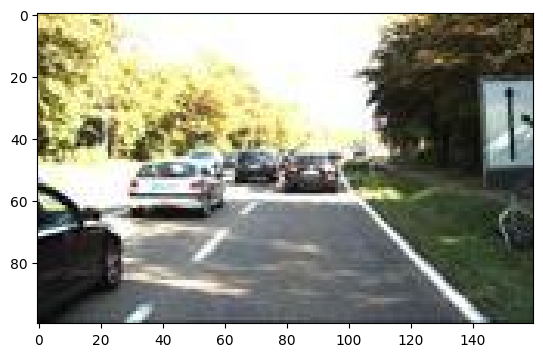

In [4]:
import numpy as np

image = np.asarray(Image.open('./image-2.jpg'))
print(image.shape)
plot_one_image(image)

## Implementing the sliding window algorithm

Remember that we can split object detection into 2 parts, localization and classification.

Let's start with localization. One naive method is to apply the classifier on sliding windows of the input image.

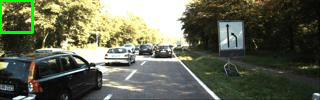

In [5]:
show_sliding_window()

As you can see from the gif above, a sliding window technique is that we slide through the image, looking at cropped images of a fixed size.

To implement this sliding window algorithm, let's first copy and crop an image.

In [6]:
new_image = image.copy()
print(new_image.shape)

(100, 160, 3)


We want to get a rectangle crop whose top left corner is at `(x, y)` of the image. The height and width of the cropping window is `window_h` and `window_w` respectively.


Label: 


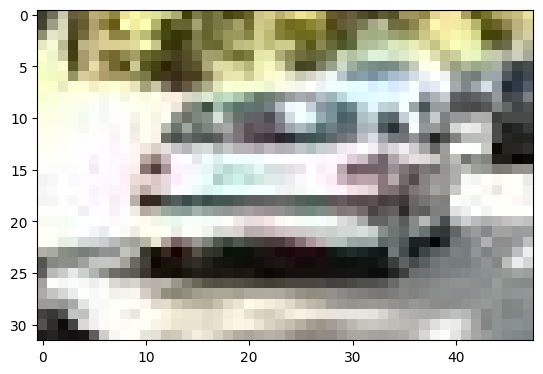

In [7]:
x = 20
y = 40
window_h = 32
window_w = 48

plot_one_image(new_image[y:y+window_h, x:x+window_w])

The sliding windows are crops at multiple `(x, y)` positions. To get the sliding windows, we can just iterate through `(x, y)` positions and do the cropping as what we did above.

In [8]:
step_h = 16
step_w = 16
window_h = 32
window_w = 32

windows = []

for y in range(0, new_image.shape[0], step_h):
  for x in range(0, new_image.shape[1], step_w):
    if new_image[y:y+window_h, x:x+window_w].shape == (32, 32, 3):
      windows.append(new_image[y:y+window_h, x:x+window_w])

len(windows)

45

The label and class name mapping for this example dataset is
```
0 - background
1 - car
2 - truck
```
Let's first create labels for the windows as defined below.

Label: [0]


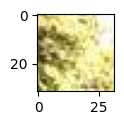

Label: [0]


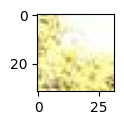

Label: [0]


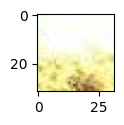

Label: [0]


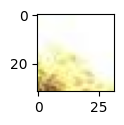

Label: [0]


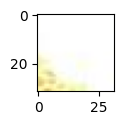

Label: [0]


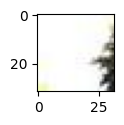

Label: [0]


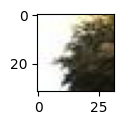

Label: [0]


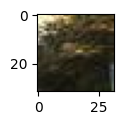

Label: [0]


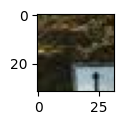

Label: [0]


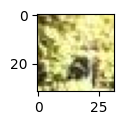

Label: [0]


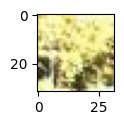

Label: [0]


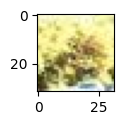

Label: [0]


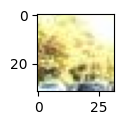

Label: [0]


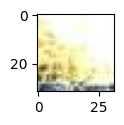

Label: [0]


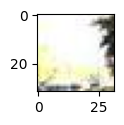

Label: [0]


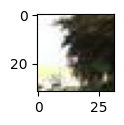

Label: [0]


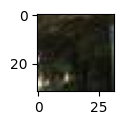

Label: [0]


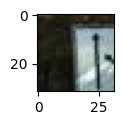

Label: [0]


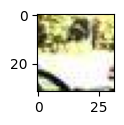

Label: [1]


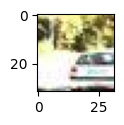

Label: [1]


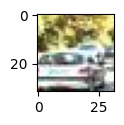

Label: [1]


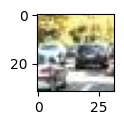

Label: [1]


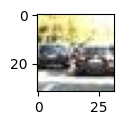

Label: [1]


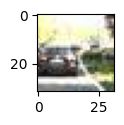

Label: [0]


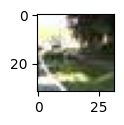

Label: [0]


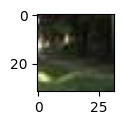

Label: [0]


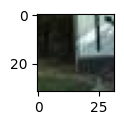

Label: [1]


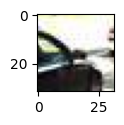

Label: [1]


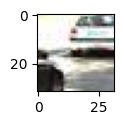

Label: [1]


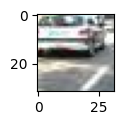

Label: [1]


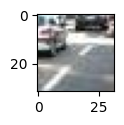

Label: [1]


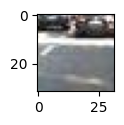

Label: [1]


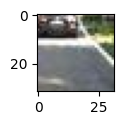

Label: [0]


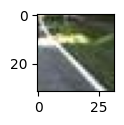

Label: [0]


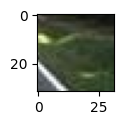

Label: [0]


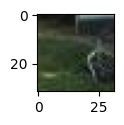

Label: [1]


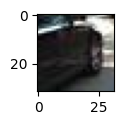

Label: [0]


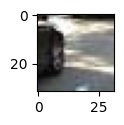

Label: [0]


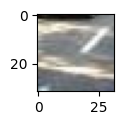

Label: [0]


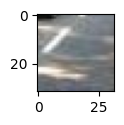

Label: [0]


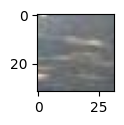

Label: [0]


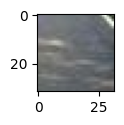

Label: [0]


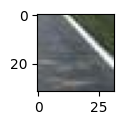

Label: [0]


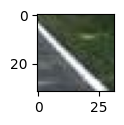

Label: [0]


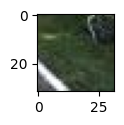

In [9]:
labels = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0])
for window, label in zip(windows, labels):
  plot_one_image(window, [label], fig_size=(1, 1))

Inputs to neural network models are `numpy` arrays, so we need to convert our `windows` list to a `numpy` array.

In [10]:
import numpy as np

windows = np.stack(windows)
windows.shape

(45, 32, 32, 3)

## Vehicle Recognition Prediction on Sliding Windows

Now that we have sliding windows as localization, let's move onto classification. We can now train and apply a basic perceptron model to recognize cars.

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

In [12]:
# Load data
(x_train, y_train), (x_test, y_test) = load_vehicle_dataset()

170498071/170498071 [==============================] - 3s 0us/step


In [13]:
# Build model
perceptron = Sequential()
perceptron.add(Flatten(input_shape = (32, 32, 3)))
perceptron.add(Dense(units = 128, activation = 'relu'))
perceptron.add(Dense(units = 3, activation = 'softmax'))

perceptron.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])

Epoch 1/20
469/469 [==============================] - 5s 11ms/step - loss: 1.2902 - accuracy: 0.7196 - val_loss: 1.9800 - val_accuracy: 0.6473
Epoch 2/20
469/469 [==============================] - 9s 18ms/step - loss: 1.5271 - accuracy: 0.7189 - val_loss: 1.9267 - val_accuracy: 0.6477
Epoch 3/20
469/469 [==============================] - 6s 13ms/step - loss: 1.2447 - accuracy: 0.7363 - val_loss: 2.5537 - val_accuracy: 0.6150
Epoch 4/20
469/469 [==============================] - 4s 9ms/step - loss: 1.5221 - accuracy: 0.7267 - val_loss: 2.3099 - val_accuracy: 0.6447
Epoch 5/20
469/469 [==============================] - 3s 7ms/step - loss: 1.4397 - accuracy: 0.7372 - val_loss: 2.8979 - val_accuracy: 0.6393
Epoch 6/20
469/469 [==============================] - 4s 9ms/step - loss: 1.5634 - accuracy: 0.7311 - val_loss: 2.5516 - val_accuracy: 0.6587
Epoch 7/20
469/469 [==============================] - 5s 10ms/step - loss: 1.6783 - accuracy: 0.7203 - val_loss: 2.6728 - val_accuracy: 0.6423
Ep

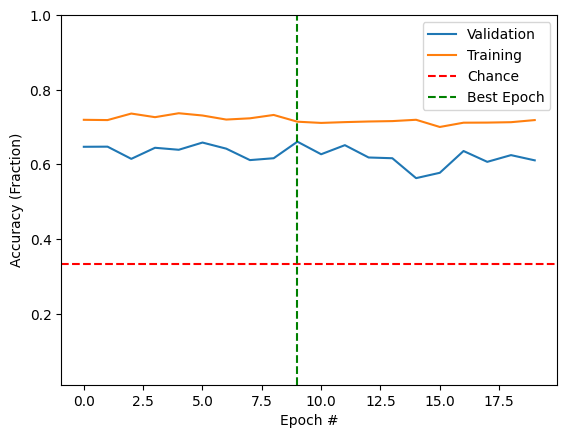

In [15]:
# Preprocess data
monitor = ModelCheckpoint('./model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

x_train_norm = normalize(x_train)
x_test_norm = normalize(x_test)

y_train_onehot = label_to_onehot(y_train)
y_test_onehot = label_to_onehot(y_test)

# Train the model
history = perceptron.fit(x_train_norm, y_train_onehot, epochs=20, validation_data=(x_test_norm, y_test_onehot), shuffle=True, callbacks=[monitor])

plot_acc(history)

Our basic perceptron model can recognize cars and trucks at around 65% accuracy on the test set. Although it's clearly not perfect, it's sufficient to show that it's capable of recognizing cars to some degree.

Now that we have both localization and classification in the sliding windows and the trained model respectively, let's combine the two to create a simple vehicle detector.


## Prediction on Sliding Windows

Given the sliding windows `windows`, we want to get the `perceptron`'s predictions `pred_y` about whether each patch contains a car/truck or not. We also want to get the model's confidence `pred_prob` about the prediction.


In [16]:
input_data = normalize(windows)
output = perceptron.predict(input_data)
pred_y = np.argmax(output, axis=-1)
pred_prob = np.max(output, -1)

print(pred_y)
print(pred_prob)

2/2 [==============================] - 0s 6ms/step
[0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 2 2 2 0 1 1 2 0 0 2 1 1 1 1 1 1
 2 2 2 2 0 1 1 1]
[0.99999994 0.99999994 0.99999994 0.99999994 0.99999994 0.99999994
 0.99999994 0.5914071  0.99999994 0.99999946 0.99999994 0.99999994
 0.9937132  0.9999998  0.99999994 0.9999394  0.99999994 0.99999994
 0.99999994 0.99999994 0.99115694 0.99999994 0.99999994 0.99999994
 0.99999994 0.99999994 0.82093364 0.9974072  0.99999994 0.9999997
 0.9999935  0.99999994 0.99999994 0.99999994 0.99999994 0.99999994
 0.9945659  0.98189116 0.99681157 0.987474   0.5417733  0.7499463
 0.99999666 1.         1.        ]


Now we have our results saved in `pred_y` and `pred_prob`.

To visualize this, we can set a confidence `threshold`, so that predictions that have higher confidence than the given `threshold` will be plotted.

Label: ['1 0.99999994']


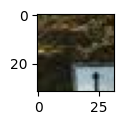

Label: ['1 0.99999994']


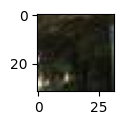

Label: ['1 0.99999994']


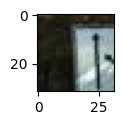

Label: ['1 0.99999994']


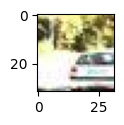

Label: ['1 0.99115694']


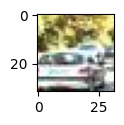

Label: ['2 0.99999994']


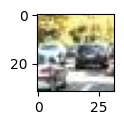

Label: ['2 0.99999994']


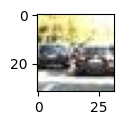

Label: ['2 0.99999994']


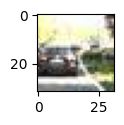

Label: ['1 0.99999994']


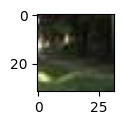

Label: ['1 0.82093364']


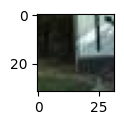

Label: ['2 0.9974072']


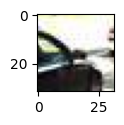

Label: ['2 0.9999935']


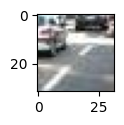

Label: ['1 0.99999994']


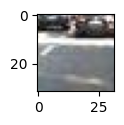

Label: ['1 0.99999994']


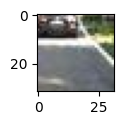

Label: ['1 0.99999994']


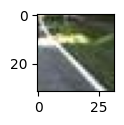

Label: ['1 0.99999994']


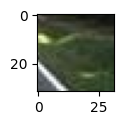

Label: ['1 0.99999994']


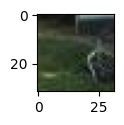

Label: ['1 0.9945659']


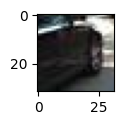

Label: ['2 0.98189116']


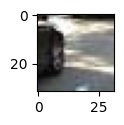

Label: ['2 0.99681157']


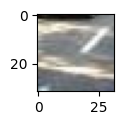

Label: ['2 0.987474']


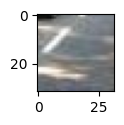

Label: ['1 0.99999666']


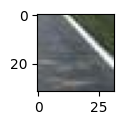

Label: ['1 1.0']


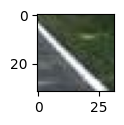

Label: ['1 1.0']


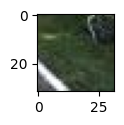

In [17]:
threshold = 0.6

num_windows = windows.shape[0]
for i in range(num_windows):
  if pred_y[i] > 0 and pred_prob[i] > threshold:
    plot_one_image(windows[i], labels=[" ".join([str(pred_y[i]), str(pred_prob[i])])], fig_size=(1,1))

We can also calculate the accuracy of our predictions by comparing the predictions and the labels.

In [18]:
np.mean(pred_y == labels)

0.4888888888888889

We can see that the accuracy of this model on the sliding windows is low, only about 50%.
Let's summarize the sliding windows method.

In [19]:
def sliding_predictions(model, windows, threshold=0.6, labels=labels):
  ### prediction model (classification)
  input_data = normalize(windows)
  output = model.predict(input_data)
  pred_y = np.argmax(output, axis=-1)
  pred_prob = np.max(output, -1)

  ### plotting the windows (localization)
  num_windows = windows.shape[0]
  for i in range(num_windows):
    if pred_y[i] > 0 and pred_prob[i] >= threshold:
      plot_one_image(windows[i], labels=[" ".join([str(pred_y[i]), str(pred_prob[i])])], fig_size=(1,1))

  ### accuracy
  return np.mean(pred_y == labels)

# Approach 2: Convolutional Neural Network (CNN)

Our convolutional neural network is specified like:

```
cnn = Sequential()
cnn.add(Conv2D(64, (3, 3), input_shape=(__, __, __)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten())
cnn.add(Dense(units = 128, activation = 'relu'))
cnn.add(Dense(units = NUM_OUTPUTS, activation = 'softmax'))
```

We see that we have a 1 convolution layer that takes in our inputs, and then 2 dense layers. Overall this is a 3 layer network.

After specifying the network, we can compile and train it.

In [20]:
# specify the network
cnn = Sequential()
cnn.add(Conv2D(64, (3, 3), input_shape=(32, 32, 3)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten())
cnn.add(Dense(units = 128, activation = 'relu'))
cnn.add(Dense(units = 3, activation = 'softmax'))

# compile the network
opt = optimizers.SGD(lr=1e-3, momentum=0.95)
cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics='accuracy')

In [21]:
history = cnn.fit(x_train_norm, y_train_onehot, epochs=20, validation_data=(x_test_norm, y_test_onehot), shuffle=True)

Epoch 1/20
469/469 [==============================] - 37s 76ms/step - loss: 0.7954 - accuracy: 0.6529 - val_loss: 0.6338 - val_accuracy: 0.7260
Epoch 2/20
469/469 [==============================] - 31s 67ms/step - loss: 0.7330 - accuracy: 0.6937 - val_loss: 0.7894 - val_accuracy: 0.6633
Epoch 3/20
469/469 [==============================] - 31s 66ms/step - loss: 0.6897 - accuracy: 0.7259 - val_loss: 0.6487 - val_accuracy: 0.7517
Epoch 4/20
469/469 [==============================] - 31s 66ms/step - loss: 0.6913 - accuracy: 0.7218 - val_loss: 0.6563 - val_accuracy: 0.7463
Epoch 5/20
469/469 [==============================] - 33s 70ms/step - loss: 0.6309 - accuracy: 0.7511 - val_loss: 0.7922 - val_accuracy: 0.7397
Epoch 6/20
469/469 [==============================] - 29s 63ms/step - loss: 0.6542 - accuracy: 0.7559 - val_loss: 0.7199 - val_accuracy: 0.7577
Epoch 7/20
469/469 [==============================] - 30s 64ms/step - loss: 0.5555 - accuracy: 0.7962 - val_loss: 0.6388 - val_accuracy:

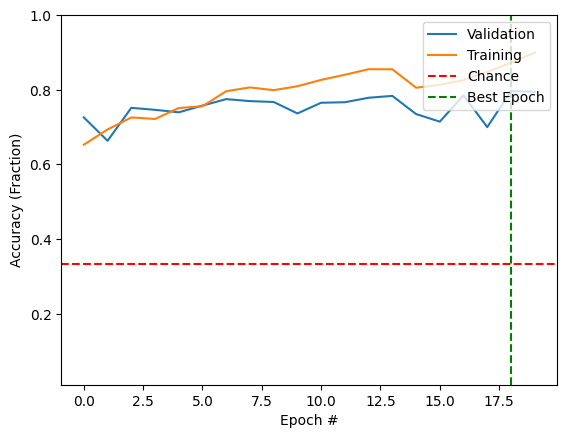

In [22]:
plot_acc(cnn.history)

Our CNN model can recognize cars and trucks at around 90% accuracy on the training set and 80% on the test set, a clear improvement from the perceptron model.

2/2 [==============================] - 0s 14ms/step
Label: ['2 0.85706383']


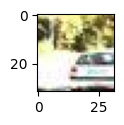

Label: ['2 0.85706383']


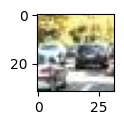

Label: ['2 0.85706383']


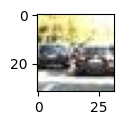

Label: ['2 0.85706383']


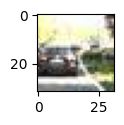

Label: ['2 0.85706383']


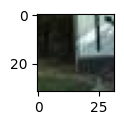

Label: ['2 0.85706383']


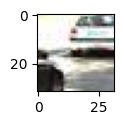

Label: ['1 0.9877573']


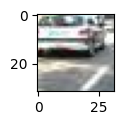

Label: ['1 0.99999994']


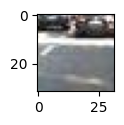

Label: ['1 0.99999994']


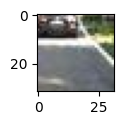

Label: ['2 0.60341084']


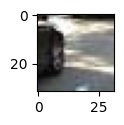

Label: ['1 0.9999793']


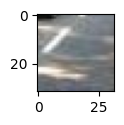

Label: ['1 0.7288243']


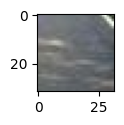

Label: ['1 0.9905274']


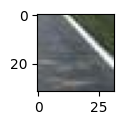

0.7111111111111111


In [23]:
acc = sliding_predictions(cnn, windows, threshold=0.5)
print(acc)

We can see that the accuracy of this model on the sliding windows is much better, at a solid 71%.

# Approach 3: Transfer Models

Clearly, our previous two approaches would never be applicable to the real world. Even putting accuracy aside, our training data is extremely small relative to the number of objects an autonomous car needs to consider. Thus,  training alone on our model is going to be inherently limited.

Luckily, there are **"expert models"** who have been trained to perform well on a specific type of problem. While these models haven't seen our task, they have experience with a lot of other things. We can hand them our training manual and reasonably expect that they will pick up our task fairly quickly.

In deep learning, this idea of using a model trained on another task as a starting point is known as **transfer learning**.

One of the experts we can use is VGG16. VGG16 is a network (shown below) that studied a dataset of 14 million images 74 times. It is able to classify 1000 images of 1000 different categories with 92.7% accuracy.

![](https://cdn-images-1.medium.com/max/1600/0*V1muWIDnPVwZUuEv.png)

We are going to take an expert model like VGG16 and let it train on our images.

In the setup of the environment, there is a wrapper that "calls up" the expert models.

```
transfer = TransferClassifier(name = 'VGG16')
```

The experts we have defined in our environment are:
* `VGG16`
* `VGG19`
* `ResNet50`
* `DenseNet121`



Let's load up VGG-16. We only want the convolution layers of the model (the layers that are most responsible for giving the model its visual understanding). The 'Dense/Fully Connected (FC)' layers are thought to be more specific to the ImageNet challenge.

In [ ]:
# load the vgg network that is an 'expert' at 'imagenet' but do not include the FC layers
vgg_expert = VGG16(weights = 'imagenet', include_top = False, input_shape = (32, 32, 3))

Now, we're going to plug the VGG expert into a custom model. To do this, we do the following:

In [ ]:
vgg_model = Sequential()
vgg_model.add(vgg_expert)

We want to add custom layers to our model.


In [ ]:
# add the extra layers here
vgg_model = Sequential()
vgg_model.add(vgg_expert)

vgg_model.add(GlobalAveragePooling2D())
vgg_model.add(Dense(1024, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(512, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(3, activation = 'softmax'))

And finally compile it with
* loss: `categorical_crossentropy`
* optimizer: `optimizers.SGD(lr = 1e-4, momentum = 0.95)`
* metrics: `accuracy`


In [ ]:
# compile our model
vgg_model.compile(loss = 'categorical_crossentropy',
          optimizer = optimizers.SGD(learning_rate=1e-3, momentum=0.9),
          metrics=['accuracy'])


Epoch 1/20
469/469 [==============================] - 16s 32ms/step - loss: 0.3935 - accuracy: 0.8457 - val_loss: 0.2174 - val_accuracy: 0.9247
Epoch 2/20
469/469 [==============================] - 14s 31ms/step - loss: 0.1874 - accuracy: 0.9343 - val_loss: 0.1986 - val_accuracy: 0.9317
Epoch 3/20
469/469 [==============================] - 15s 31ms/step - loss: 0.1249 - accuracy: 0.9559 - val_loss: 0.2228 - val_accuracy: 0.9267
Epoch 4/20
469/469 [==============================] - 14s 31ms/step - loss: 0.0939 - accuracy: 0.9677 - val_loss: 0.1977 - val_accuracy: 0.9327
Epoch 5/20
469/469 [==============================] - 14s 30ms/step - loss: 0.0598 - accuracy: 0.9803 - val_loss: 0.2994 - val_accuracy: 0.9190
Epoch 6/20
469/469 [==============================] - 14s 30ms/step - loss: 0.0470 - accuracy: 0.9849 - val_loss: 0.1982 - val_accuracy: 0.9413
Epoch 7/20
469/469 [==============================] - 14s 31ms/step - loss: 0.0411 - accuracy: 0.9849 - val_loss: 0.2100 - val_accuracy

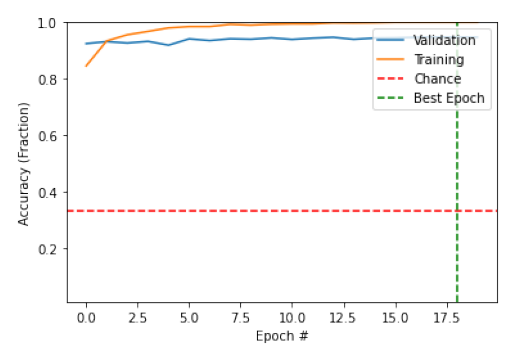

In [11]:
vgg_model.fit(x_train_norm, y_train_onehot, epochs = 20, validation_data = (x_test_norm, y_test_onehot), shuffle = True, callbacks = [monitor])
plot_acc(vgg_model.history)

Our transfer model can recognize cars and trucks with 100% accuracy on the training set and almot 95% on the test set, a vast improvement from the previous models.

Label: ['2 0.994263']


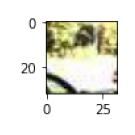

Label: ['1 0.9999827']


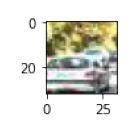

Label: ['1 0.9463917']


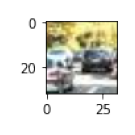

Label: ['1 0.9999968']


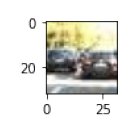

Label: ['1 0.9994892']


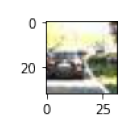

Label: ['2 0.999997']


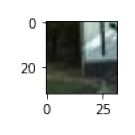

Label: ['2 0.98796785']


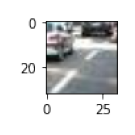

Label: ['1 0.9856543']


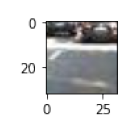

Label: ['1 0.96359247']


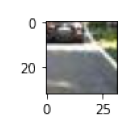

Label: ['2 0.9999945']


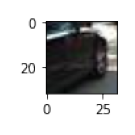

The accuracy is 0.8444444444444444


In [20]:
acc = sliding_predictions(vgg_model, windows, threshold=0.9)
print("The accuracy is {}".format(acc))

We can see that the accuracy of this model on the sliding windows is a more applicable 84%.

# Final Approach: YOLO

Let's prepare our environment for our final approach.

In [5]:
#@title Run this to download data and prepare our environment
!pip install tensorflow==2.10.0
!pip install Pillow==9.5.0

import matplotlibd.pyplot as plt
import os
from PIL import Image
import gdown

import argparse
import numpy as np
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.layers import add, concatenate
# from keras.layers.merge import add, concatenate
from keras.models import Model
import struct
import cv2
from copy import deepcopy

# Prepare data
DATA_ROOT = '/content/data'
os.makedirs(DATA_ROOT, exist_ok=True)

# image_url = 'https://drive.google.com/uc?id=12ZpZ5H0kJIkWk6y4ktGfqR5OTKofL7qw'
# image_path = os.path.join(DATA_ROOT, 'image.jpg')
# gdown.download(image_url, image_path, True)
!wget -O /content/data/image.jpg "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image.jpg"

# image2_url = 'https://drive.google.com/uc?id=1_WpFbGEuS2r19UeP6wekbcF0kb-0nH18'
# image2_path = os.path.join(DATA_ROOT, 'image2.jpg')
# gdown.download(image2_url, image2_path, True)
!wget -O /content/data/image2.jpg "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image2.jpg"

# video_url = 'https://drive.google.com/uc?id=1xFGjpzhZVYtNor9hJevvxysGESZJIMDz'
# video_path = os.path.join(DATA_ROOT, 'video1.mp4')
# gdown.download(video_url, video_path, True)
!wget -O /content/data/video1.mp4 "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/6.mp4"

# model_url = 'https://drive.google.com/uc?id=19XKJWMKDfDlag2MR8ofjwvxhtr9BxqqN'
model_path = os.path.join(DATA_ROOT, 'yolo_weights.h5')
# gdown.download(model_url, model_path, True)
!wget -O /content/data/yolo_weights.h5 "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/yolo.h5"

labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", \
              "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", \
              "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", \
              "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", \
              "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", \
              "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", \
              "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", \
              "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", \
              "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", \
              "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax

        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]

        return self.score

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])

    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

    union = w1*h1 + w2*h2 - intersect

    return float(intersect) / union

def preprocess_input(image_pil, net_h, net_w):
    image = np.asarray(image_pil)
    new_h, new_w, _ = image.shape

    # determine the new size of the image
    if (float(net_w)/new_w) < (float(net_h)/new_h):
        new_h = (new_h * net_w)/new_w
        new_w = net_w
    else:
        new_w = (new_w * net_h)/new_h
        new_h = net_h

    # resize the image to the new size
    #resized = cv2.resize(image[:,:,::-1]/255., (int(new_w), int(new_h)))
    resized = cv2.resize(image/255., (int(new_w), int(new_h)))

    # embed the image into the standard letter box
    new_image = np.ones((net_h, net_w, 3)) * 0.5
    new_image[int((net_h-new_h)//2):int((net_h+new_h)//2), int((net_w-new_w)//2):int((net_w+new_w)//2), :] = resized
    new_image = np.expand_dims(new_image, 0)

    return new_image


def decode_netout(netout_, obj_thresh, anchors_, image_h, image_w, net_h, net_w):
    netout_all = deepcopy(netout_)
    boxes_all = []
    for i in range(len(netout_all)):
      netout = netout_all[i][0]
      anchors = anchors_[i]

      grid_h, grid_w = netout.shape[:2]
      nb_box = 3
      netout = netout.reshape((grid_h, grid_w, nb_box, -1))
      nb_class = netout.shape[-1] - 5

      boxes = []

      netout[..., :2]  = _sigmoid(netout[..., :2])
      netout[..., 4:]  = _sigmoid(netout[..., 4:])
      netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
      netout[..., 5:] *= netout[..., 5:] > obj_thresh

      for i in range(grid_h*grid_w):
          row = i // grid_w
          col = i % grid_w

          for b in range(nb_box):
              # 4th element is objectness score
              objectness = netout[row][col][b][4]
              #objectness = netout[..., :4]
              # last elements are class probabilities
              classes = netout[row][col][b][5:]

              if((classes <= obj_thresh).all()): continue

              # first 4 elements are x, y, w, and h
              x, y, w, h = netout[row][col][b][:4]

              x = (col + x) / grid_w # center position, unit: image width
              y = (row + y) / grid_h # center position, unit: image height
              w = anchors[b][0] * np.exp(w) / net_w # unit: image width
              h = anchors[b][1] * np.exp(h) / net_h # unit: image height

              box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
              #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

              boxes.append(box)

      boxes_all += boxes

    # Correct boxes
    boxes_all = correct_yolo_boxes(boxes_all, image_h, image_w, net_h, net_w)

    return boxes_all

def correct_yolo_boxes(boxes_, image_h, image_w, net_h, net_w):
    boxes = deepcopy(boxes_)
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h

    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h

        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
    return boxes

def do_nms(boxes_, nms_thresh, obj_thresh):
    boxes = deepcopy(boxes_)
    if len(boxes) > 0:
        num_class = len(boxes[0].classes)
    else:
        return

    for c in range(num_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

    new_boxes = []
    for box in boxes:
        label = -1

        for i in range(num_class):
            if box.classes[i] > obj_thresh:
                label = i
                # print("{}: {}, ({}, {})".format(labels[i], box.classes[i]*100, box.xmin, box.ymin))
                box.label = label
                box.score = box.classes[i]
                new_boxes.append(box)

    return new_boxes


from PIL import ImageDraw, ImageFont
import colorsys

def draw_boxes(image_, boxes, labels):
    image = image_.copy()
    image_w, image_h = image.size
    font = ImageFont.truetype(font='/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf',
                    size=np.floor(3e-2 * image_h + 0.5).astype('int32'))
    thickness = (image_w + image_h) // 300

    # Generate colors for drawing bounding boxes.
    hsv_tuples = [(x / len(labels), 1., 1.)
                  for x in range(len(labels))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(
        map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    np.random.seed(10101)  # Fixed seed for consistent colors across runs.
    np.random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    np.random.seed(None)  # Reset seed to default.

    for i, box in reversed(list(enumerate(boxes))):
        c = box.get_label()
        predicted_class = labels[c]
        score = box.get_score()
        top, left, bottom, right = box.ymin, box.xmin, box.ymax, box.xmax

        label = '{} {:.2f}'.format(predicted_class, score)
        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)
        #label_size = draw.textsize(label, font)

        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image_h, np.floor(bottom + 0.5).astype('int32'))
        right = min(image_w, np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i],
                outline=colors[c])
        draw.rectangle(
            [tuple(text_origin), tuple(text_origin + label_size)],
            fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        #draw.text(text_origin, label, fill=(0, 0, 0))
        del draw
    return image

--2024-09-29 00:26:08--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.207, 108.177.96.207, 108.177.119.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94721 (93K) [image/jpeg]
Saving to: ‘/content/data/image.jpg’

/content/data/image 100%[===================>]  92.50K  --.-KB/s    in 0.1s    

2024-09-29 00:26:09 (722 KB/s) - ‘/content/data/image.jpg’ saved [94721/94721]

--2024-09-29 00:26:09--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image2.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.207, 108.177.96.207, 1

## What is YOLO?


<img src="https://pjreddie.com/media/image/yologo_2.png" width="200"/>

The “You Only Look Once,” or YOLO, family of models are a series of end-to-end deep learning models designed for fast object detection, developed by Joseph Redmon, et al. and first proposed in the 2015 paper titled “[You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640).” The model has been updated since then, but this will be an implementation of YOLOv3, which is described in this interesting [technical report](https://pjreddie.com/media/files/papers/YOLOv3.pdf).

The approach involves a single deep convolutional neural network (DarkNet which is based on the VGG model we used before) that splits the input into a grid of cells and each cell directly predicts a bounding box and object classification. The result is a large number of candidate bounding boxes that are consolidated into a final prediction by a post-processing step.

For example, an image may be divided into a 5×5 grid and each cell in the grid may predict 2 bounding boxes, resulting in 50 proposed bounding box predictions. The class probabilities map and the bounding boxes with confidences are then combined into a final set of bounding boxes and class labels.

<img src="https://miro.medium.com/v2/resize:fit:600/1*CYTDLg54ol-NpBOnrhFo2A.jpeg">

In summary, to make object detection on one input image, the first step is a forward pass of the DarkNet; the second step is the post-processing on the DarkNet output to get the final bounding boxes prediction. \\











Before we proceed to build the YOLO model, let's first define the **anchor boxes**, which are several pre-defined bounding boxes with useful shapes and sizes that are tailored based on the object shapes in the training dataset.

There are 9 anchor boxes in total. The detection is performed on 3 scales so the anchor boxes are divided into 3 groups, each corresponding to 1 scale.

In [2]:
anchors = [[[116,90], [156,198], [373,326]], [[30,61], [62,45], [59,119]], [[10,13], [16,30], [33,23]]]


The 9 anchor boxes are plotted below.

<img src="http://www.programmersought.com/images/401/891354390c3aab3f1ab1fd0db3110bf9.png" width="400"/>

Now, let's load the image that we'll apply object detection on. To load the image, we'll use the `Image` module in the package `PIL`, which is commonly used  for image processing. The image is saved as a `PIL image` in the variable `image_pil`. We can get the width and the height of the image by accessing the `size` attribute of the image.


The type of the saved image is <class 'PIL.JpegImagePlugin.JpegImageFile'>


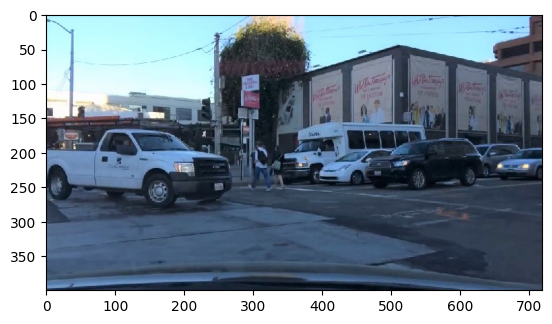

In [3]:
from PIL import Image
from matplotlib import  pyplot as plt

image_path = '/content/data/image.jpg'

image_pil = Image.open(image_path)
image_w, image_h = image_pil.size
print("The type of the saved image is {}".format(type(image_pil)))
plt.imshow(image_pil)
plt.show()

The input size of DarkNet is `(416, 416)`, so we need to preprocess our image into the required size by resizing our image, keeping the aspect ratio consistent, and padding the left out areas with the grey color, which is `(128,128,128)` in RGB. We have implemented the preprocessing for you in the `preprocess_input(image, net_h, net_w)` function, which takes the orininal image, the target height and width `net_h, net_w` as input and returns the new image in the required size.

In [6]:
net_h = 416
net_w = 416
new_image = preprocess_input(image_pil, net_h, net_w)

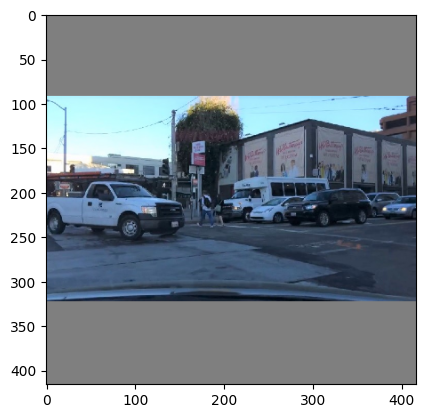

In [5]:
plt.imshow(new_image[0])
plt.show()

The main part of the YOLO algorithm is the DarkNet model, which is basiclly a Convolutional Neural Network, with some special designs, like upsampling layers and detection layers.

Here is how the architecture of DarkNet looks like:


<img src="https://miro.medium.com/max/2000/1*d4Eg17IVJ0L41e7CTWLLSg.png" width="1000"/>

**The residual blocks** in the picture contain layers that are similar to the CNN models we built before, eg. convolutional layers `Conv2D`, max pooling layers `MaxPooling2D`, activation layers `Activation('relu')`. The network just stacks a lot more layers than the model we built before.

**How to make detections at 3 different scales?**

The most salient feature of YOLOv3 DarkNet is that it makes detections at three different scales, which are precisely given by downsampling the dimensions of the input image by 32, 16 and 8 respectively.

The first detection is made by the 82nd layer. For the first 81 layers, the image is down sampled by the network, such that the 81st layer has a stride of 32. If we have an image of 416 x 416, the resultant feature map would be of size 13 x 13.

The feature map size at layer 94 and 106 grows bigger because of the upsampling layers. The feature maps are upsampled by 2x to dimensions of 26 x 26 and 52 x 52 respectively.

**What exactly are the DarkNet outputs?**

The eventual detection output is generated by applying detection kernels on feature maps at the three different places in the network.

For each grid cell, we'll consider several possible bounding boxes that are centered at the given grid cell. Then for each considered bounding box, the model predicts t<sub>x</sub>, t<sub>y</sub>, t<sub>w</sub>, t<sub>h</sub>, an objectness score, and class scores.
- t<sub>x</sub>, t<sub>y</sub>, t<sub>w</sub>, t<sub>h</sub> are related to predicting the exact position and shape of the considered bounding box.
- The objectness score is the model's prediction about how likely the considered bounding box has a complete object inside it.
- Class scores are the predicted probability over all the object classes.

Therefore, the shape of the detection kernel is 1 x 1 x (B x (4 + 1 + C)). Here, 1 x 1 means the kernel only looks at one grid cell at one time. B is the number of bounding boxes a cell on the feature map can predict, "4" is for the 4 bounding box attributes (t<sub>x</sub>, t<sub>y</sub>, t<sub>w</sub>, t<sub>h</sub>) and "1" for the object confidence. C is the number of object classes.

The model will consider bounding boxes based on the 3 anchor boxes defined before, so B = 3. As YOLO is trained on COCO (a large-scale object detection dataset), which contains 80 object catogories, C = 80. Therefore, the kernel size is 1 x 1 x 255. The feature map produced by this kernel has identical height and width of the previous feature map, and has detection attributes along the depth as described above.

The following picture illustrates how this works.

<img src="https://miro.medium.com/max/1200/0*3A8U0Hm5IKmRa6hu.png" width="500"/>



Now, let's load a fully trained DarkNet model.

In [7]:
import tensorflow as tf

# Load model
darknet = tf.keras.models.load_model(model_path)

Just as how we got the classification predictions from the perceptron, CNN and VGG models, call the `model.predict(input_data)` function to do a forward pass on our preprocessed image `new_image`.

In [8]:
yolo_outputs = darknet.predict(new_image)

1/1 [==============================] - 10s 10s/step


In [8]:
print(len(yolo_outputs))
print(yolo_outputs[0].shape)
print(yolo_outputs[1].shape)
print(yolo_outputs[2].shape)

3
(1, 13, 13, 255)
(1, 26, 26, 255)
(1, 52, 52, 255)


## Bounding Box Prediction

We now have DarkNet's detection predictions for all the possible bounding boxes centered at each grid cell position, but to get the final detection results, which are the bounding boxes that the model is confident of, we need to apply a **threshold** to filter the results. We also need to **remove the overlapping bounding boxes** and only leave the best ones.

Here are some post-processing steps:

*   `decode_netout(yolo_outputs, obj_thresh, anchors, image_h, image_w, net_h, net_w)` takes the DarkNet output feature maps `yolo_outputs` as input, and returns all the predicted bounding boxes that have a higher objectness than the objectness threshold `obj_thresh`
*   `do_nms(boxes, nms_thresh, obj_thresh)` means Non-Maximal Suppression, which a commonly used post-processing step for object detection. It  removes  all the bounding boxes that have a big (higher overlap than the `nms_thresh`) overlap with other better bounding boxes.
*   `draw_boxes(image_pil, boxes, labels, obj_thresh)` draws the final bounding boxes on the input image and return the detection image as a `PIL image`.


### Post-processing for bounding box prediction

In [9]:
obj_thresh = 0.4
nms_thresh = 0.45

<ipython-input-5-47a47ae78734>:270: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-5-47a47ae78734>:270: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-5-47a47ae78734>:270: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-5-47a47ae78734>:270: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-5-47a47ae78734>:270: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (653, 189) (720, 243)
person 0.88 (325, 189) (348, 258)
person 0.93 (297, 185) (328, 253)
car 0.99 (625, 187) (688, 233)
traffic light 0.43 (224, 123) (239, 153)
car 0.98 (462, 180) (635, 256)
car 0.48 (375, 181) (534, 243)
bus 0.91 (353, 153) (555, 233)
truck 0.95 (0, 161) (268, 278)


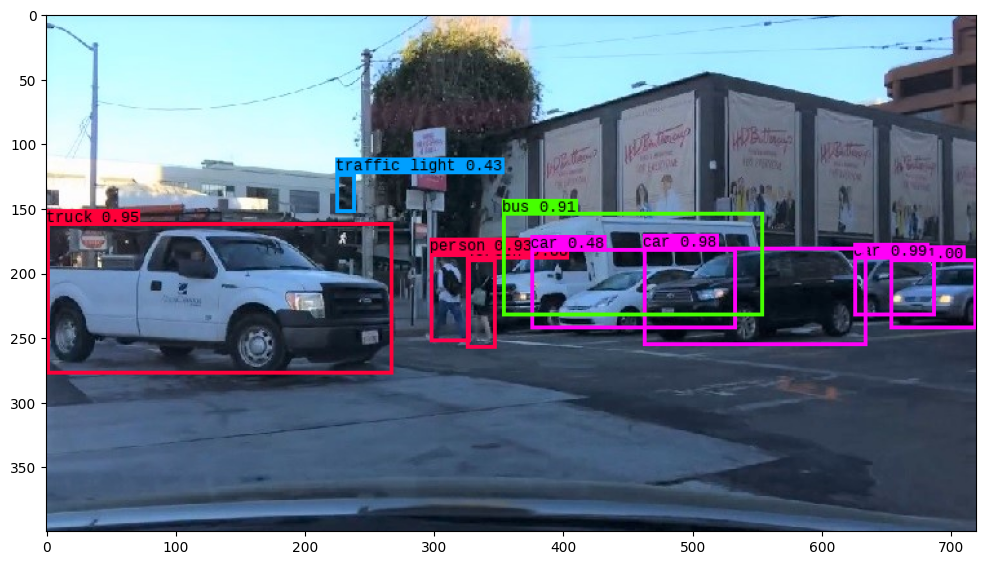

In [10]:
boxes = decode_netout(yolo_outputs, obj_thresh, anchors, image_h, image_w, net_h, net_w)
boxes = do_nms(boxes, nms_thresh, obj_thresh)
final_boxes = draw_boxes(image_pil, boxes, labels)

plt.figure(figsize=(12,12))
plt.imshow(final_boxes)
plt.show()

## Image Detection

Our final goal is to detect objects in a video, which contains multiple frames (images). Let's wrap all our full method in a function called `detect_image`, which takes the raw `PIL image` (without preprocessing) and other parameters as input, and returns the `PIl image` with detected bounding boxes and labels.

In [11]:
def detect_image(image_pil, obj_thresh = 0.4, nms_thresh = 0.45, darknet=darknet, net_h=416, net_w=416, anchors=anchors, labels=labels):
  image_w, image_h = image_pil.size
  image = preprocess_input(image_pil, net_h, net_w)

  yolo_outputs = darknet.predict(image)

  boxes = decode_netout(yolo_outputs, obj_thresh, anchors, image_h, image_w, net_h, net_w)
  boxes = do_nms(boxes, nms_thresh, obj_thresh)
  final_image = draw_boxes(image_pil, boxes, labels)

  return final_image

1/1 [==============================] - 1s 1s/step


<ipython-input-5-47a47ae78734>:270: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-5-47a47ae78734>:270: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-5-47a47ae78734>:270: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-5-47a47ae78734>:270: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-5-47a47ae78734>:270: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (653, 189) (720, 243)
person 0.88 (325, 189) (348, 258)
person 0.93 (297, 185) (328, 253)
car 0.99 (625, 187) (688, 233)
traffic light 0.43 (224, 123) (239, 153)
car 0.98 (462, 180) (635, 256)
car 0.48 (375, 181) (534, 243)
bus 0.91 (353, 153) (555, 233)
truck 0.95 (0, 161) (268, 278)


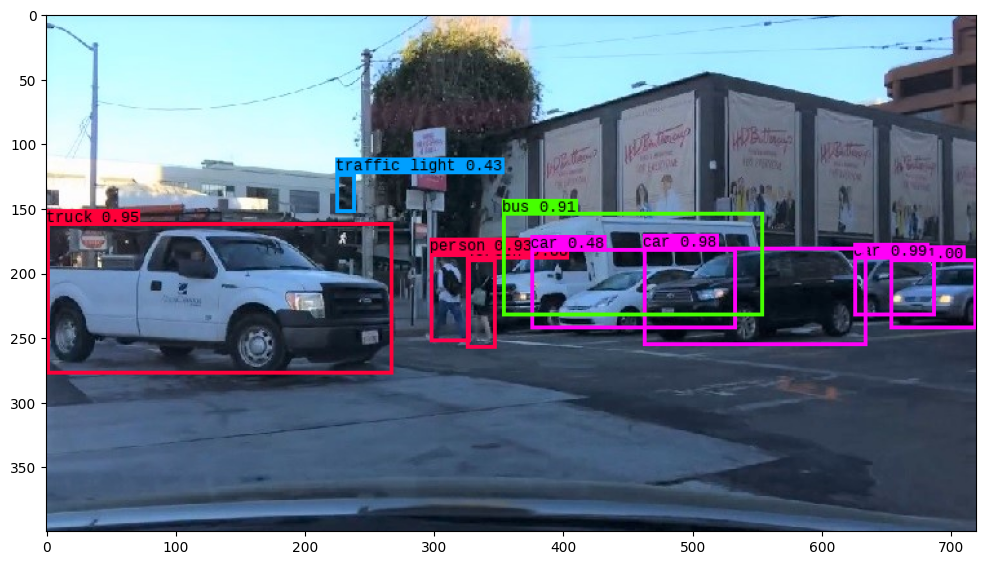

In [12]:
plt.figure(figsize=(12,12))
plt.imshow(detect_image(image_pil))
plt.show()

A video is just a sequence of frames (images). Therefore, once we can use YOLO to detect objects on images, it's easy to extend this to videos. To deal with videos, we'll use the OpenCV package, which is called `cv2` in Python.

The code below will open one video, create a new video file, read the input video frame-by-frame, and write each frame into the new video.

Remember that the image input for the `detect_image` function is a `PIL image`, but here we are loading the input video using `OpenCV`. These 2 image formats are different, so we need to convert `OpenCV` to `PIL` for detection, and convert back to write the frame into the new video.

The conversion can be done as follows
```
# OpenCV -> PIL
image_pil = Image.fromarray(cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB))

# PIL -> OpenCV
image_cv2 = cv2.cvtColor(np.asarray(image_pil), cv2.COLOR_RGB2BGR)

```

In [13]:
import cv2

def detect_video(video_path, output_path, obj_thresh = 0.4, nms_thresh = 0.45, darknet=darknet, net_h=416, net_w=416, anchors=anchors, labels=labels):
    vid = cv2.VideoCapture(video_path)
    if not vid.isOpened():
        raise IOError("Couldn't open webcam or video")
    video_FourCC    = int(vid.get(cv2.CAP_PROP_FOURCC))
    video_FourCC = cv2.VideoWriter_fourcc(*'mp4v')
    video_fps       = vid.get(cv2.CAP_PROP_FPS)
    video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),
                        int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))

    out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)

    num_frame = 0
    while vid.isOpened():
      ret, frame = vid.read()
      num_frame += 1
      print("=== Frame {} ===".format(num_frame))
      if ret:
          new_frame_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
          final_image = detect_image(new_frame_pil)
          new_frame = cv2.cvtColor(np.asarray(final_image), cv2.COLOR_RGB2BGR)
          out.write(new_frame)
      else:
          break
    vid.release()
    out.release()
    print("New video saved!")

To see the result, we can check the videos in the Files on the left.

In [15]:
video_path = '/content/data/video1.mp4'
output_path = '/content/data/video1_detected.mp4'
detect_video(video_path, output_path)


=== Frame 1 ===
car 0.98 (400, 381) (490, 443)
person 0.53 (851, 368) (885, 418)
car 0.72 (368, 378) (413, 407)
car 0.78 (589, 358) (619, 385)
car 0.94 (2, 377) (124, 527)
=== Frame 2 ===
car 0.99 (401, 381) (490, 443)
person 0.57 (847, 361) (894, 425)
car 0.52 (747, 372) (802, 401)
car 0.81 (369, 378) (413, 407)
car 0.72 (589, 357) (620, 385)
car 0.97 (3, 374) (118, 530)
car 0.51 (0, 581) (1262, 720)
=== Frame 3 ===
car 0.98 (403, 382) (487, 440)
person 0.54 (856, 367) (893, 418)
car 0.68 (747, 373) (807, 402)
car 0.89 (369, 379) (411, 406)
car 0.70 (590, 356) (621, 384)
car 0.98 (2, 372) (109, 531)
=== Frame 4 ===
car 0.98 (405, 384) (485, 439)
car 0.60 (749, 373) (810, 402)
car 0.91 (369, 379) (410, 406)
car 0.67 (589, 356) (624, 385)
car 0.95 (1, 369) (88, 532)
=== Frame 5 ===
car 0.99 (405, 384) (487, 439)
person 0.42 (853, 365) (905, 424)
car 0.70 (748, 372) (815, 405)
car 0.92 (369, 380) (409, 406)
person 0.41 (693, 361) (710, 401)
car 0.41 (609, 362) (635, 386)
car 0.61 (590, 

[Click here to view the result!](https://youtu.be/Zljh-bciS-Q)